Ancova hours, something else? Add same_day to model.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import pdb
%matplotlib inline

We created a new feature, prev_no_show, in another notebook and saved the resulting dataframe. We'll load it here so we don't have to create the feature again.

In [79]:
df = pd.read_csv('no_show_prev_adj_2.csv', index_col=0)

A helper function to return accuracy and predictions that allows us to vary the prediction threshold.

In [80]:
def get_perf(model, X, y, thresh = 0.5):
    probs = model.predict_proba(X)
    preds =  [1 if p >= thresh else 0 for p in probs[:, 1]]
    return (preds == y).sum() / len(y), probs, preds

In [81]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,...,no_show,scheduledday_year,scheduledday_month,scheduledday_dow,appointmentday_year,appointmentday_month,appointmentday_dow,scheduledday_hour,date_diff,prev_no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29 00:00:00,62,JARDIM DA PENHA,0,1,0,...,0,2016,4,4,2016,4,4,18,0,0.0
2151,725775968562,5521232,M,2016-03-29 11:09:08,2016-04-29 00:00:00,33,MARIA ORTIZ,0,0,0,...,0,2016,3,1,2016,4,4,11,31,0.0
2152,94755722517728,5521230,F,2016-03-29 11:08:52,2016-04-29 00:00:00,50,MARIA ORTIZ,0,0,0,...,0,2016,3,1,2016,4,4,11,31,0.0
2153,35387553979251,5523393,F,2016-03-29 17:04:40,2016-04-29 00:00:00,69,MARIA ORTIZ,0,0,0,...,0,2016,3,1,2016,4,4,17,31,0.0
2154,732498986588399,5642808,F,2016-04-29 17:21:24,2016-04-29 00:00:00,65,MARIA ORTIZ,0,0,0,...,0,2016,4,4,2016,4,4,17,0,0.0


In [82]:
df.isnull().sum()

patientid               0
appointmentid           0
gender                  0
scheduledday            0
appointmentday          0
age                     0
neighbourhood           0
scholarship             0
hipertension            0
diabetes                0
alcoholism              0
handcap                 0
sms_received            0
no_show                 0
scheduledday_year       0
scheduledday_month      0
scheduledday_dow        0
appointmentday_year     0
appointmentday_month    0
appointmentday_dow      0
scheduledday_hour       0
date_diff               0
prev_no_show            0
dtype: int64

In [83]:
df.dtypes

patientid                 int64
appointmentid             int64
gender                   object
scheduledday             object
appointmentday           object
age                       int64
neighbourhood            object
scholarship               int64
hipertension              int64
diabetes                  int64
alcoholism                int64
handcap                   int64
sms_received              int64
no_show                   int64
scheduledday_year         int64
scheduledday_month        int64
scheduledday_dow          int64
appointmentday_year       int64
appointmentday_month      int64
appointmentday_dow        int64
scheduledday_hour         int64
date_diff                 int64
prev_no_show            float64
dtype: object

In [84]:
df['patientid'] = df.patientid.astype(str)

Parse dates and add date_diff feature.

In [85]:
for col in ['scheduledday', 'appointmentday']:
    df[col] = pd.to_datetime(df[col])
    df[col+'_year'] = df[col].dt.year
    df[col+'_month'] = df[col].dt.month
    df[col+'_dow'] = df[col].dt.dayofweek
    df['scheduledday_hour'] = df.scheduledday.dt.hour
df['date_diff'] = (df.appointmentday.dt.date - df.scheduledday.dt.date).dt.days 

Create feature indicating if the appointment occured on the same day it was scheduled.

In [86]:
df['same_day'] = (df.appointmentday.dt.date == df.scheduledday.dt.date).astype(int)

Label encode gender and neighborhood and drop unneeded columns.

In [87]:
df['gender'] = LabelEncoder().fit_transform(df.gender)
df['neighbourhood'] = LabelEncoder().fit_transform(df.neighbourhood)
df.drop(['patientid', 'appointmentid', 'appointmentday', 'scheduledday'], axis=1, inplace=True)

In [88]:
df.columns

Index(['gender', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show',
       'scheduledday_year', 'scheduledday_month', 'scheduledday_dow',
       'appointmentday_year', 'appointmentday_month', 'appointmentday_dow',
       'scheduledday_hour', 'date_diff', 'prev_no_show', 'same_day'],
      dtype='object')

# Random Forest

#### Determine Hyperparameters

In [14]:
rf = RandomForestClassifier(random_state=17)
p_grid = {'n_estimators':[50, 80, 100], 'max_depth':[8, 10,15]}
gs = GridSearchCV(rf, p_grid, verbose=10)
gs.fit(df.drop('no_show', axis=1), df.no_show)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, n_estimators=50 ....................................
[CV]  max_depth=8, n_estimators=50, score=0.8005048448823385, total=   1.5s
[CV] max_depth=8, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=8, n_estimators=50, score=0.8020519501669245, total=   1.4s
[CV] max_depth=8, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV]  max_depth=8, n_estimators=50, score=0.7997882793626666, total=   1.4s
[CV] max_depth=8, n_estimators=80 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV]  max_depth=8, n_estimators=80, score=0.8009662622479168, total=   2.3s
[CV] max_depth=8, n_estimators=80 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s


[CV]  max_depth=8, n_estimators=80, score=0.801699101593247, total=   2.4s
[CV] max_depth=8, n_estimators=80 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s remaining:    0.0s


[CV]  max_depth=8, n_estimators=80, score=0.8000325724057435, total=   2.3s
[CV] max_depth=8, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.6s remaining:    0.0s


[CV]  max_depth=8, n_estimators=100, score=0.8010748310398176, total=   3.0s
[CV] max_depth=8, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.1s remaining:    0.0s


[CV]  max_depth=8, n_estimators=100, score=0.8016176749993215, total=   3.0s
[CV] max_depth=8, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.7s remaining:    0.0s


[CV]  max_depth=8, n_estimators=100, score=0.7999511413913846, total=   2.9s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.1s remaining:    0.0s


[CV]  max_depth=10, n_estimators=50, score=0.8012648264256439, total=   1.7s
[CV] max_depth=10, n_estimators=50 ...................................
[CV]  max_depth=10, n_estimators=50, score=0.8014548218114703, total=   1.7s
[CV] max_depth=10, n_estimators=50 ...................................
[CV]  max_depth=10, n_estimators=50, score=0.7999239977199316, total=   1.7s
[CV] max_depth=10, n_estimators=80 ...................................
[CV]  max_depth=10, n_estimators=80, score=0.8012919686236192, total=   2.8s
[CV] max_depth=10, n_estimators=80 ...................................
[CV]  max_depth=10, n_estimators=80, score=0.8017262437912223, total=   2.8s
[CV] max_depth=10, n_estimators=80 ...................................
[CV]  max_depth=10, n_estimators=80, score=0.8001140034201026, total=   2.7s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8009934044458921, total=   3.4s
[CV] max_depth=10, n_estimators=10

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 80, 100], 'max_depth': [8, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [15]:
gs.best_params_, gs.best_score_

({'max_depth': 10, 'n_estimators': 80}, 0.80104408877468858)

#### Performance evaluation

Split into train and validation set.

In [89]:
tr, test = train_test_split(df, test_size=0.2, random_state=17, stratify=df.no_show.values)
len(tr), len(test)

(88421, 22106)

In [90]:
X_tr = tr.drop('no_show', axis=1) 
X_test = test.drop('no_show', axis=1)
y_tr = tr.no_show
y_test = test.no_show

In [91]:
X_tr.shape, y_tr.shape, X_test.shape, y_test.shape

((88421, 19), (88421,), (22106, 19), (22106,))

Fit model with all the features, so we get a baseline level of performance.

In [93]:
base_rf = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=17)
base_rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [115]:
base_acc, probs, preds = get_perf(base_rf, X_test, y_test, thresh=0.5)
acc

0.80236134985976659

In [95]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn,fp, fn,tp

(17560, 82, 4287, 177)

In [96]:
cm = confusion_matrix(y_test, preds)

In [97]:
cm

array([[17560,    82],
       [ 4287,   177]])

A plotting function from the scikit-learn docs.

In [98]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fontsize=18,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,  fontsize=14, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=20 ,color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.savefig('confusion_mat.png')


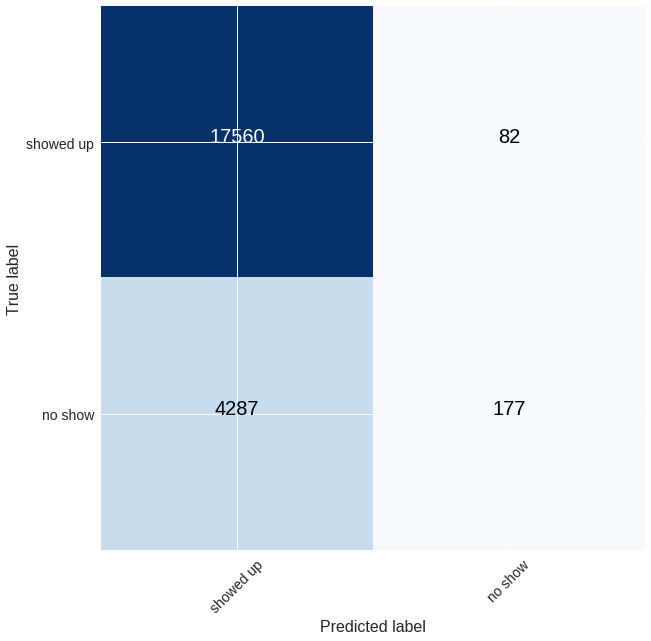

In [99]:
plot_confusion_matrix(cm, ['showed up', 'no show'])

We see above that the majority of our errors are false negatives.

Below, we plot the distribution of predicted probabilities of a no show. Our model seems to be very confident that many of the appointments in the validation set are not no shows. Then there is a smaller group of appointments that it's not so sure about, but that it still thinks are probably negatives.

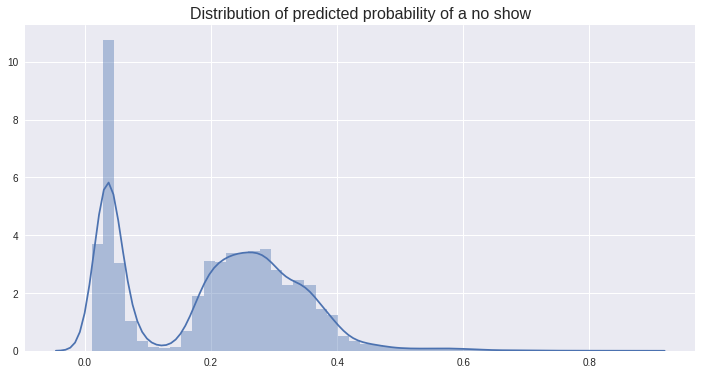

In [100]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
sns.distplot(probs[:, 1], ax=ax)
ax.set_title('Distribution of predicted probability of a no show', fontsize=16)

Below, we take the rows our model predicted was a no show and compare the distribution of some of their features to the entire dataset. Notice the difference between the distributions for date_diff and scheduledday_month, a feature that roughly measures the same thing as date_diff.

In [101]:
pos_pred_ix = probs[:, 1] > 0.5

In [102]:
pos_pred_ix.sum()

259

In [103]:
pos_preds = X_test[pos_pred_ix]
pos_preds.shape

(259, 19)

In [104]:
def plotDists(df1, df2, col, title):
    fig, axes = plt.subplots(1,2, figsize=(14, 6))
    axes = axes.ravel()
    ax1 = axes[0]
    ax2 = axes[1]
    sns.distplot(df1[col], ax=ax1)
    sns.distplot(df2[col], ax=ax2)
    ax1.set_title(title, fontsize=16)
    ax2.set_title('Entire dataset', fontsize=16)

def plotCounts(df1, df2, col, title):
    fig, axes = plt.subplots(1,2, figsize=(14, 6))
    axes = axes.ravel()
    ax1 = axes[0]
    ax2 = axes[1]
    sns.countplot(df1[col], ax=ax1)
    sns.countplot(df2[col], ax=ax2)
    ax1.set_title(title, fontsize=16)
    ax2.set_title('Entire dataset', fontsize=16)


In [105]:
title = 'Predicted no shows'

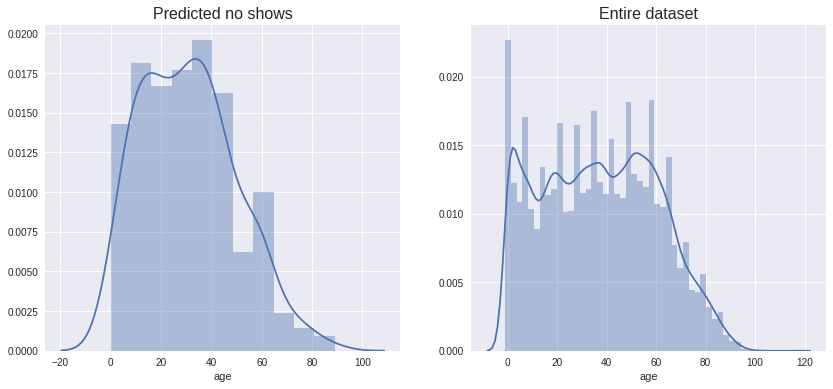

In [106]:
plotDists(pos_preds, df, 'age', title)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


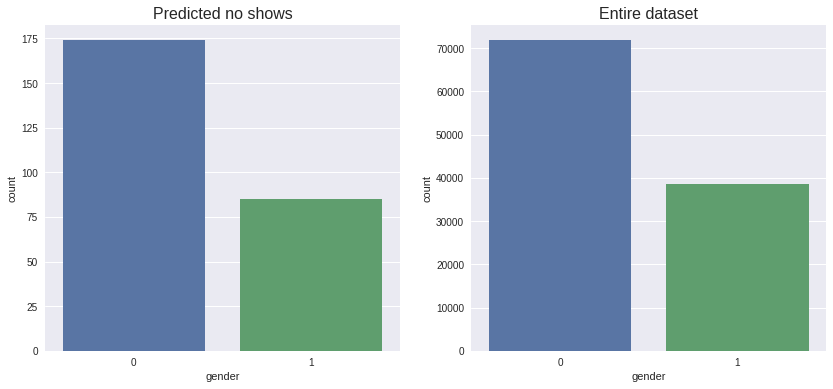

In [107]:
plotCounts(pos_preds, df, 'gender', title)

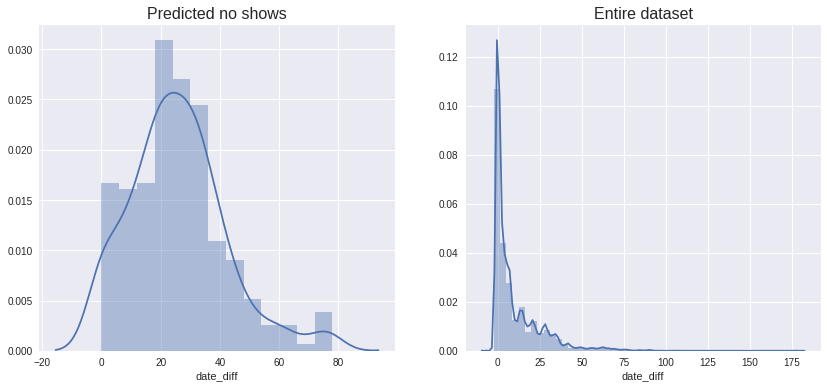

In [108]:
plotDists(pos_preds, df, 'date_diff', title)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


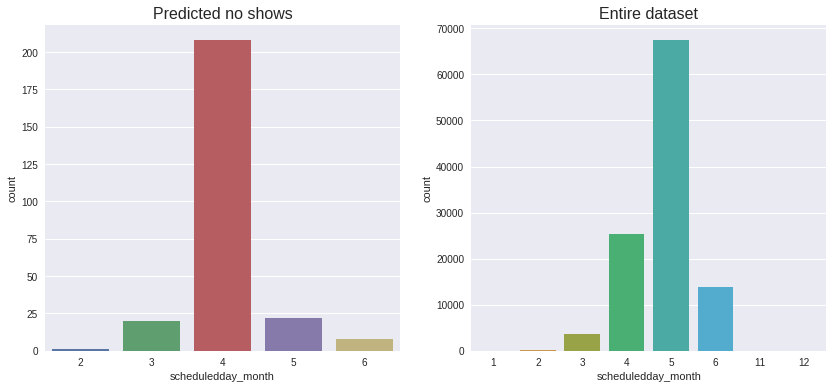

In [109]:
plotCounts(pos_preds, df, 'scheduledday_month', title)

Below, we look at the distribution of date_diff for appointments our model was confident weren't no shows. Notice that all of them are same day appointments.

In [110]:
sure_neg_ix = probs[:, 1] < 0.1
sure_neg_ix.sum()

7398

In [111]:
sure_neg = X_test[sure_neg_ix]
sure_neg.shape

(7398, 19)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


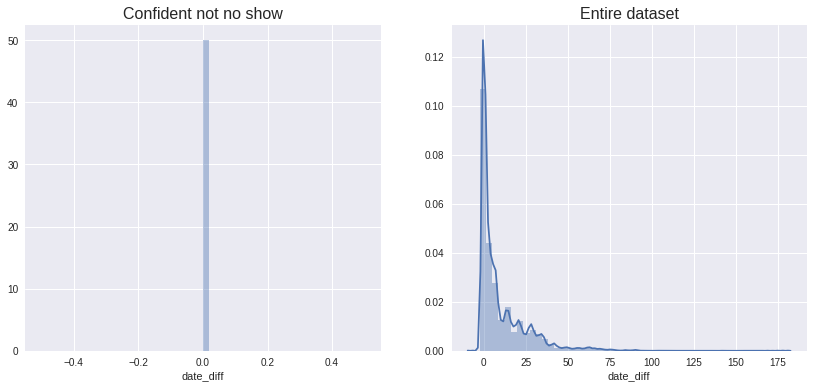

In [112]:
title = 'Confident not no show'
plotDists(sure_neg, df, 'date_diff', title)

#### Feature Importances

Let's first look at the default feature importances our random forest provides.

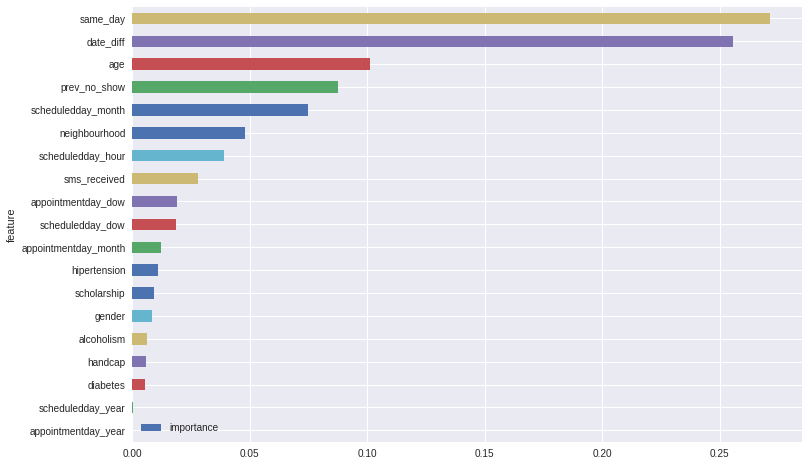

In [113]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
feat_imp = pd.DataFrame(columns=['feature', 'importance'])
feat_imp['feature'] = X_tr.columns
feat_imp['importance'] = base_rf.feature_importances_
feat_imp.sort_values('importance', ascending=True).plot(kind='barh', x='feature', y='importance', ax=ax)

Features corresponding to the time between the scheduling date and appointment date (same_day, date_diff, and scheduledday_month) are near the top. Age, neighborhood and previous no shows

#### Drop Column Importances

As noted [here](http://parrt.cs.usfca.edu/doc/rf-importance/index.html), the default feature importances provided by scikit-learn can be misleading. We'll try two alternate approaches. In the first, we loop through all of our features, train a model without the current feature, then compare its performance to the performance of the original model (above) trained with all the features. The drop in accuracy between the new model and the original model is that feature's importance.

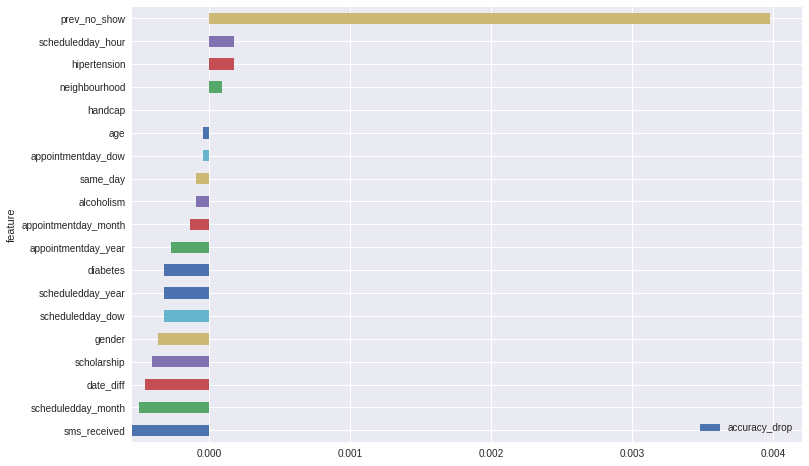

In [118]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

imps = []
for col in X_tr:
    X_tr_mod = X_tr.drop(col, axis=1)
    rf = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=17)
    rf.fit(X_tr_mod, y_tr)
    imps.append((base_acc - ((rf.predict(X_test.drop(col, axis=1)) == y_test).sum() / len(y_test)), col))

drop_imps = pd.DataFrame(imps, columns=['accuracy_drop', 'feature'])

drop_imps.sort_values('accuracy_drop').plot(kind='barh', x='feature', y='accuracy_drop', ax=ax)

With this approach, prev_no_show is by far the most important feature. It also seems that dropping many of the columns would imporve accuracy. However, notice the values on the x-axis -- the changes in accuracy for all the columns are less than .5%.

#### Permutation Importances

Instead of dropping features one by one, we could instead shuffle their values. This approach is much faster as we don't have to train a new model for each feature.

In [124]:
def shuffleCol(df, col):
    return np.random.permutation(df[col].values)

In [125]:
df.age.head()

0       62
2151    33
2152    50
2153    69
2154    65
Name: age, dtype: int64

In [127]:
shuffleCol(df, 'age')[:6]

array([28, 22, 60, 12, 32, 19])

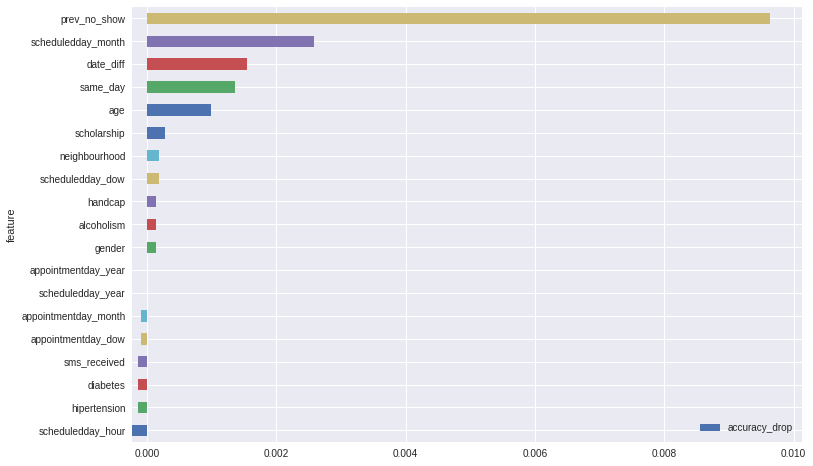

In [132]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

imps = []
for col in X_tr:
    X_test_mod = X_test.copy()
    X_test_mod[col] = shuffleCol(X_test_mod, col)
    imps.append((base_acc - ((base_rf.predict(X_test_mod) == y_test).sum() / len(y_test)), col))

perm_imps = pd.DataFrame(imps, columns=['accuracy_drop', 'feature'])

perm_imps.sort_values('accuracy_drop').plot(kind='barh', x='feature', y='accuracy_drop', ax=ax)

# Logistic Regression

Let's also try a logistic regression model. Below is a helper function to prepare the data for the model.

In [135]:
def preprocess_lr(df, dummy_cols, cont_cols,drop_col=None):
    #make copies so as to not modify in place
    df = df.copy(); dummy_cols = list(dummy_cols); cont_cols = list(cont_cols)
    
    #drop col for calculating feature importances
    if drop_col:
        if drop_col in dummy_cols: dummy_cols.remove(drop_col)
        if drop_col in cont_cols: cont_cols.remove(drop_col)
        df = df.drop(drop_col, axis=1)
    
    #one-hot encode columns
    dummies = pd.get_dummies(df[dummy_cols], columns=dummy_cols)
    df.drop(dummy_cols, axis=1, inplace=True)
    df = df.merge(dummies, left_index=True, right_index=True)
    
    #split
    tr, test = train_test_split(df, test_size=0.2, random_state=17, stratify=df.no_show)
    
    #wnormalize continuous features
    for col in cont_cols:
        sc = StandardScaler()
        tr.loc[:, col] = sc.fit_transform(tr[col].values.reshape(-1,1))
        test.loc[:, col] = sc.transform(test[col].values.reshape(-1,1))
    
    return tr, test

dummy_cols = ['neighbourhood', 
              'handcap', 
              'appointmentday_dow', 
              'scheduledday_dow', 
              'scheduledday_year',
              'scheduledday_month', 
              'appointmentday_year',
             'appointmentday_month',
             'scheduledday_hour'
             ]
cont_cols = ['age', 'date_diff', 'prev_no_show']


#### Tune C

In [136]:
tr, test = preprocess_lr(df, dummy_cols, cont_cols)
lr_cv_df = pd.concat([tr, test], axis=0)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [137]:
lr_cv_df.head()

,gender,age,scholarship,hipertension,diabetes,alcoholism,sms_received,no_show,date_diff,prev_no_show,...,scheduledday_hour_12,scheduledday_hour_13,scheduledday_hour_14,scheduledday_hour_15,scheduledday_hour_16,scheduledday_hour_17,scheduledday_hour_18,scheduledday_hour_19,scheduledday_hour_20,scheduledday_hour_21
26079,1,-1.600743,0,0,0,0,0,0,-0.668589,-0.316171,...,0,0,0,0,0,0,0,0,0,0
47882,0,0.302716,0,0,0,0,1,0,0.515371,-0.316171,...,0,0,0,0,0,0,0,0,0,0
56298,0,-0.475971,0,0,0,0,0,1,-0.142384,-0.316171,...,1,0,0,0,0,0,0,0,0,0
76134,0,0.778581,1,0,0,0,0,0,-0.668589,1.224623,...,0,0,0,0,0,0,0,0,0,0
44922,1,1.297706,0,1,0,0,0,0,-0.602813,-0.316171,...,0,0,0,0,0,0,0,0,0,0


In [147]:
lr = LogisticRegression()
p_grid = {'penalty':['l2', 'l1'], 'C':[ 0.1, 1, 10]}
gs = GridSearchCV(lr, p_grid, verbose=10)
gs.fit(lr_cv_df.drop('no_show', axis=1), lr_cv_df.no_show)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, penalty=l2 ...............................................
[CV] ...... C=0.1, penalty=l2, score=0.7996634367451076, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ...... C=0.1, penalty=l2, score=0.7986591754200255, total=   0.7s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ...... C=0.1, penalty=l2, score=0.8001411470915556, total=   0.7s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV] ....... C=0.1, penalty=l1, score=0.799446299161306, total=   2.6s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.0s remaining:    0.0s


[CV] ...... C=0.1, penalty=l1, score=0.7985777488260999, total=   4.7s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.7s remaining:    0.0s


[CV] ...... C=0.1, penalty=l1, score=0.7997882793626666, total=   0.8s
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.6s remaining:    0.0s


[CV] ........ C=1, penalty=l2, score=0.7996634367451076, total=   0.9s
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.5s remaining:    0.0s


[CV] ........ C=1, penalty=l2, score=0.7987677442119263, total=   1.0s
[CV] C=1, penalty=l2 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.6s remaining:    0.0s


[CV] ........ C=1, penalty=l2, score=0.8003854401346326, total=   0.9s
[CV] C=1, penalty=l1 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.6s remaining:    0.0s


[CV] ......... C=1, penalty=l1, score=0.799717721141058, total=  10.2s
[CV] C=1, penalty=l1 .................................................
[CV] ........ C=1, penalty=l1, score=0.7987677442119263, total=   3.1s
[CV] C=1, penalty=l1 .................................................
[CV] ........ C=1, penalty=l1, score=0.8004397274775387, total=   8.9s
[CV] C=10, penalty=l2 ................................................
[CV] ....... C=10, penalty=l2, score=0.7995277257552317, total=   1.3s
[CV] C=10, penalty=l2 ................................................
[CV] ....... C=10, penalty=l2, score=0.7987406020139511, total=   1.6s
[CV] C=10, penalty=l2 ................................................
[CV] ....... C=10, penalty=l2, score=0.8003040091202737, total=   1.6s
[CV] C=10, penalty=l1 ................................................
[CV] ....... C=10, penalty=l1, score=0.7995548679532068, total=   1.4s
[CV] C=10, penalty=l1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   47.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [148]:
gs.best_score_

0.79964171650365978

In [149]:
gs.best_params_

{'C': 1, 'penalty': 'l1'}

In [152]:
tr, test = preprocess_lr(df, dummy_cols, cont_cols)
X_tr = tr.drop('no_show', axis=1) 
X_test = test.drop('no_show', axis=1)
y_tr = tr.no_show
y_test = test.no_show
base_lr = LogisticRegression(penalty='l1', C=1)
base_lr.fit(X_tr, y_tr)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.799828100968063

In [153]:
acc, probs, preds = get_perf(base_lr, X_test, y_test, 0.49)
acc

0.79964715461865554

In [154]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn,fp, fn,tp

(17477, 165, 4264, 200)

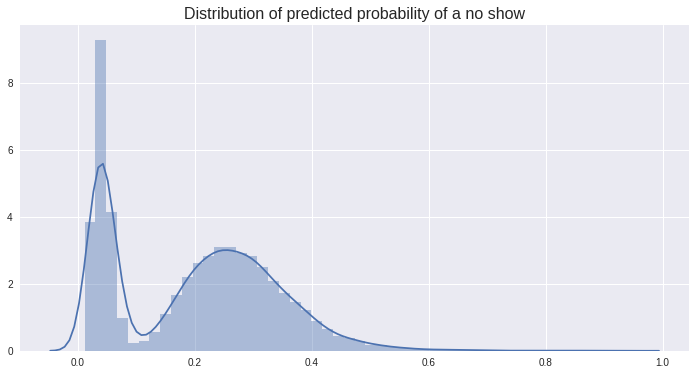

In [156]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
sns.distplot(probs[:, 1], ax=ax)
ax.set_title('Distribution of predicted probability of a no show', fontsize=16)

Drop column accuracy

In [158]:
acc_drop = []
for col in df.drop('no_show', axis=1).columns:
    tr, test = preprocess_lr(df, dummy_cols, cont_cols, col)
    X_tr = tr.drop('no_show', axis=1) 
    X_test = test.drop('no_show', axis=1)
    y_tr = tr.no_show
    y_test = test.no_show
    lr = LogisticRegression(penalty='l1', C=1)
    lr.fit(X_tr, y_tr)
    acc, probs, preds = get_perf(lr, X_test, y_test)
    acc_drop.append((base_acc - acc, col))

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


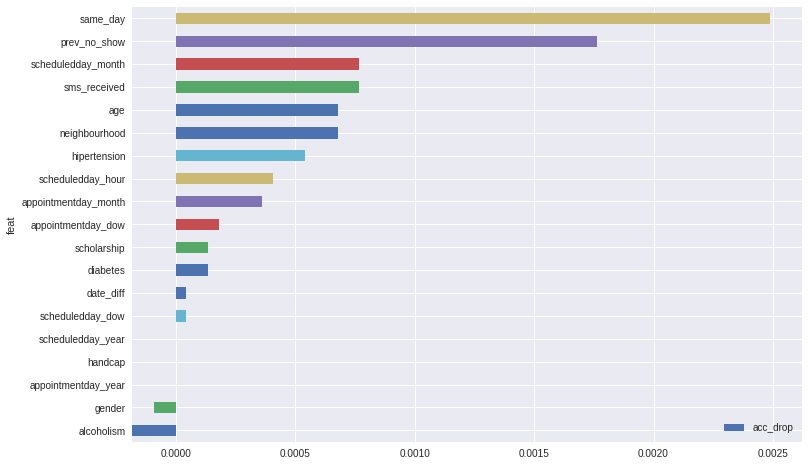

In [159]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
pd.DataFrame(acc_drop, columns=['acc_drop', 'feat' ]).sort_values('acc_drop').plot(kind='barh', x='feat', y='acc_drop', ax=ax)